# Extreme Gradient Boosting with XGBoost

## Regression

In [1]:
import xgboost as xgb
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

california_housing = fetch_california_housing(as_frame=True)

# Convert to Pandas
housing = pd.DataFrame(data=california_housing.data, columns=california_housing.feature_names)
housing["target"] = california_housing.target
housing.head()

/home/david_stroud/anaconda3/envs/stroud/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Decision trees as base learners
- Split df into training and testing sets, holding out 20% for testing. Use a random_state of 123.
- Instantiate the XGBRegressor as xg_reg, using a seed of 123. Specify an objective of "reg:squarederror" and use 10 trees. Note: You don't have to specify booster="gbtree" as this is the default.
- Fit xg_reg to the training data and predict the labels of the test set. Save the predictions in a variable called preds.
- Compute the rmse using np.sqrt() and the mean_squared_error() function from sklearn.metrics

In [ ]:
# Create arrays for the features and the target: X, y
X, y = housing.iloc[:,:-1], housing.iloc[:,-1]

# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=123)

# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, seed=123)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.544916

### Linear base learners
Now that you've used trees as base models in XGBoost, let's use the other kind of base model that can be used with XGBoost - a linear learner. This model, although not as commonly used in XGBoost, allows you to create a regularized linear regression using XGBoost's powerful learning API. However, because it's uncommon, you have to use XGBoost's own non-scikit-learn compatible functions to build the model, such as xgb.train().

- Create two DMatrix objects - DM_train for the training set (X_train and y_train), and DM_test (X_test and y_test) for the test set.
- Create a parameter dictionary that defines the "booster" type you will use ("gblinear") as well as the "objective" you will minimize ("reg:linear").
- Train the model using xgb.train(). You have to specify arguments for the following parameters: params, dtrain, and num_boost_round. Use 5 boosting rounds.
- Predict the labels on the test set using xg_reg.predict(), passing it DM_test. Assign to preds.

In [ ]:
# Convert the training and testing sets in DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test = xgb.DMatrix(data=X_test, label=y_test)

# Create the paramater dictionary: params
params = {"booster":"gblinear", "objective":"reg:squarederror"}

# Train the model: xg_reg
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=5)

# Predict the labels on the test set: preds
preds = xg_reg.predict(DM_test)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 2.407643

### Evaluate model quality

Here, you will compare the RMSE and MAE of a cross-validated XGBoost model on the California housing data.
- First test is **MAE**
- Second test is **RMSE**

[MAE and RMSE - Which Metric is Better?](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d)

In [ ]:
# Create the DMatrix: housing _dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the paramater dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, metrics="mae",
                   as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print firnal round boosting round metric
print((cv_results["test-mae-mean"]).tail(1))

train-mae-mean train-mae-std test-mae-mean test-mae-std
0 1.120125 0.003611 1.120884 0.008643
1 0.839305 0.002111 0.841251 0.009733
2 0.675359 0.002642 0.679085 0.009385
3 0.576820 0.001640 0.581963 0.009107
4 0.507214 0.005651 0.514777 0.010908
4 0.514777
Name: test-mae-mean, dtype: float64

In [ ]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

train-rmse-mean train-rmse-std test-rmse-mean test-rmse-std
0 1.463408 0.004377 1.465911 0.012080
1 1.143686 0.003495 1.148107 0.009364
2 0.939050 0.002131 0.946055 0.008011
3 0.808920 0.003423 0.818658 0.007057
4 0.719385 0.006243 0.731978 0.007857
4 0.731978
Name: test-rmse-mean, dtype: float64

### Using regularization in XGBoost
- Create your DMatrix from X and y as before.
- Create an initial parameter dictionary specifying an "objective" of "reg:squarederror" and "max_depth" of 3.
- Use xgb.cv() inside of a for loop and systematically vary the "lambda" value by passing in the current l2 value (reg).
- Append the "test-rmse-mean" from the last boosting round for each cross-validated xgboost model.

[L1 and L2 Regularization Methods](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c)

In [ ]:
# housing_dmatrix created above
# housing_dmatrix = xgb.Dmatrix(data=X, label)

reg_params = [1, 10, 100]

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":"reg:squarederror","max_depth":3}

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# Iterate over reg_params
for reg in reg_params:
  
  # update l2 strength
  params["lambda"] = reg 
  
  # Pass this updated param dictionary into cv
  cv_results_rmse = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2, num_boost_round=5, metrics="rmse",
                          as_pandas=True, seed=123)
  
  # Append best rmse (final round) to rmses_l2
  rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])
  
# Look at the best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

Best rmse as a function of l2:
 l2 rmse
0 1 0.778195
1 10 0.783919
2 100 0.822457

### Visualizing feature importances: What features are most important in my dataset

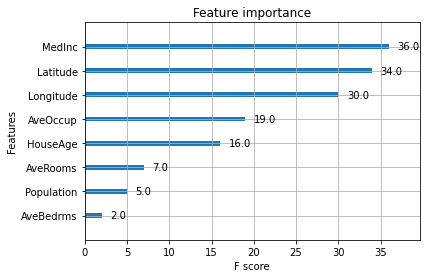

In [ ]:
# Create the DMatrix: housing_dmatrix
# housing_dmatrix = xgb.Dmatrix(data=X, label=y)

# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()